<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlxtend --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank 

In [3]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [4]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [5]:
data.head(2)

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative


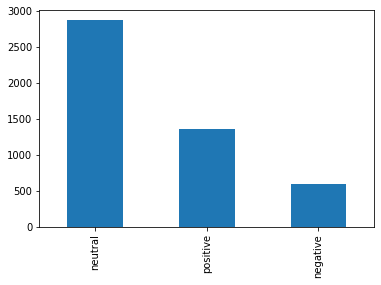

In [6]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [7]:
X= data.sentence
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60, test_size=0.2)

In [8]:
X_train.shape, X_test.shape, X.shape

((3876,), (969,), (4845,))

In [9]:
neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [10]:

# Down-sample neutral class
X_train_neu, y_train_neu = resample(X_train.loc[neu_index], y_train.loc[neu_index],
                                    n_samples=len(pos_index), replace=False,
                                    random_state=60)

# Up-sample negative class
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index],
                                    n_samples=len(pos_index), replace=True,
                                    random_state=60)

In [11]:
# Combine resampled classes
X_train_resample = X_train.loc[pos_index].append([X_train_neu, X_train_neg])
y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

# Shuffle samples
X_train_resample, y_train_resample = shuffle(X_train_resample, y_train_resample, random_state=7)

# Display new class counts
print(y_train_resample.value_counts())

neutral     1090
negative    1090
positive    1090
Name: sentiment, dtype: int64


# Prepare Data for model

In [12]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resample)
X_train_seq = tokenizer.texts_to_sequences(X_train_resample)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
# Make sequences of equal length 
max_len = np.max([len(X_train_seq[i]) for i in range(len(X_train_seq))])
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [14]:
max_len

71

In [15]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train_seq = to_categorical(le.transform(y_train_resample))
y_test_seq = to_categorical(le.transform(y_test))

# EMBEDDINGS

In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-19 03:07:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-19 03:07:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-19 03:07:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
dict_w2v = {}
with open('/content/glove.6B.100d.txt', 'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There is issue with " + word)

In [20]:
print("dictionary size :" ,len(dict_w2v) )

dictionary size : 400000


In [21]:
words_found = set()
words_not_found = set()
for word in tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)
len(words_found), len(words_not_found), len(tokenizer.word_index)

(6187, 918, 7105)

In [22]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)
embedding_matrix = np.zeros((VOCAB_SIZE +1, EMBEDDING_DIM))

In [23]:
unk_cnt = 0
unk_set = set()
for word, i in tokenizer.word_index.items():
    emb_vector = dict_w2v.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
unk_cnt

918

In [24]:
X_train_seq.shape, y_train_seq.shape

((3270, 71), (3270, 3))

Epoch 1/15
52/52 [==============================] - 5s 37ms/step - loss: 1.0829 - recall: 0.2205 - val_loss: 0.8301 - val_recall: 0.4396
Epoch 2/15
52/52 [==============================] - 1s 22ms/step - loss: 0.8875 - recall: 0.4458 - val_loss: 0.8684 - val_recall: 0.3932
Epoch 3/15
52/52 [==============================] - 1s 22ms/step - loss: 0.7417 - recall: 0.5943 - val_loss: 0.9593 - val_recall: 0.4923
Epoch 4/15
52/52 [==============================] - 1s 22ms/step - loss: 0.6309 - recall: 0.6939 - val_loss: 0.6253 - val_recall: 0.7141
Epoch 5/15
52/52 [==============================] - 1s 22ms/step - loss: 0.5403 - recall: 0.7443 - val_loss: 0.6601 - val_recall: 0.6904
Epoch 6/15
52/52 [==============================] - 1s 23ms/step - loss: 0.4487 - recall: 0.7948 - val_loss: 0.6118 - val_recall: 0.7358
Epoch 7/15
52/52 [==============================] - 1s 22ms/step - loss: 0.3714 - recall: 0.8430 - val_loss: 0.5765 - val_recall: 0.7482
Epoch 8/15
52/52 [=======================

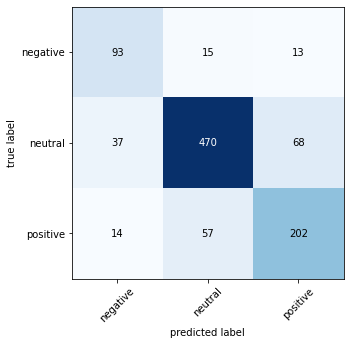

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.646     0.769       0.702        121
neutral         0.867     0.817       0.842        575
positive        0.714     0.740       0.727        273


In [146]:
np.random.seed(60)
model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len, trainable=True))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat')) #{"sum", "mul", "ave", "concat", None}
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[ 
                                                                            #  'Precision', 
                                                                             'Recall', 
                                                                            #  'accuracy'
                                                                             ])
# model.summary()

batch_size = 64
epochs = 15

model.fit(X_train_seq, y_train_seq,validation_data=(X_test_seq, y_test_seq), 
          batch_size=batch_size, verbose=1, epochs=epochs, shuffle=True)

preds = model.predict(X_test_seq, batch_size=batch_size)
true_y = np.argmax(y_test_seq, axis=1)
pred_y = np.argmax(preds, axis=1)

c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(true_y, pred_y, average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

# Prepare NEPSE DATA

In [240]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [241]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)

In [242]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)

In [243]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)

In [244]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [245]:
news_df = news_df[['date', 'content']]

In [246]:
indices

,no_name,date,index,abs_change,pct_change,target
0,1590,2014-02-02,775.92,-5.54,-0.70,0
1,1589,2014-02-03,769.51,-6.41,-0.83,0
2,1588,2014-02-04,774.91,5.40,0.70,1
3,1587,2014-02-05,781.38,6.47,0.83,1
4,1586,2014-02-06,785.78,4.40,0.56,1
...,...,...,...,...,...,...
1233,351,2019-06-24,"1,260.10",5.75,0.46,1
1234,350,2019-06-25,"1,261.07",0.96,0.08,1
1235,349,2019-06-26,"1,258.29",-2.78,-0.22,0
1236,347,2019-06-30,"1,244.89",-12.27,-0.98,0


In [247]:
indices = indices[['date','index']]

In [248]:
df = pd.merge(news_df, indices, left_on='date', right_on='date')

In [249]:
df

,date,content,index
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,775.92
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,775.92
2,2014-02-02,The government has stopped monitoring of shops...,775.92
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,775.92
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,775.92
...,...,...,...
6302,2019-06-30,Importers are being allowed to haul the goods ...,"1,244.89"
6303,2019-06-30,It will be first facility of its kind in the K...,"1,244.89"
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...","1,244.89"
6305,2019-06-30,Domestic supply has helped keep prices stable ...,"1,244.89"


In [38]:
df.to_csv('indices-news-merged.csv', index=False)
news_df.to_csv('news-cleaned.csv', index=False)
indices.to_csv('indices-cleaned.csv', index=False)

In [250]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [251]:
news_sentiment = prepare_and_predict_news(news_df['content'], pad_max_len=max_len, batch_size=batch_size)
# news_df['pred_glove_300'] = np.argmax(news_sentiment, axis=1)

In [252]:
news_sentiment

array([[0.9911248 , 0.00482204, 0.0040532 ],
       [0.00202748, 0.98241836, 0.01555424],
       [0.95916283, 0.03786442, 0.00297271],
       ...,
       [0.0104461 , 0.97088563, 0.01866833],
       [0.00496439, 0.12885894, 0.8661766 ],
       [0.01432732, 0.9795736 , 0.0060991 ]], dtype=float32)

In [253]:
news_sentiment = pd.DataFrame(news_sentiment, columns = ['neg', 'neu', 'pos'])

In [254]:
df = pd.concat([df, news_sentiment], axis=1)

In [255]:
df

,date,content,index,neg,neu,pos
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,775.92,0.991125,0.004822,0.004053
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,775.92,0.002027,0.982418,0.015554
2,2014-02-02,The government has stopped monitoring of shops...,775.92,0.959163,0.037864,0.002973
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,775.92,0.000360,0.993252,0.006388
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,775.92,0.528792,0.444913,0.026294
...,...,...,...,...,...,...
6302,2019-06-30,Importers are being allowed to haul the goods ...,"1,244.89",0.003104,0.990980,0.005916
6303,2019-06-30,It will be first facility of its kind in the K...,"1,244.89",0.000556,0.977483,0.021961
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...","1,244.89",0.010446,0.970886,0.018668
6305,2019-06-30,Domestic supply has helped keep prices stable ...,"1,244.89",0.004964,0.128859,0.866177


In [256]:
indices['neg'] = df.groupby('date')['neg'].apply(np.mean).values
indices['neu'] = df.groupby('date')['neu'].apply(np.mean).values
indices['pos'] = df.groupby('date')['pos'].apply(np.mean).values

In [257]:
indices

,date,index,neg,neu,pos
0,2014-02-02,775.92,0.496293,0.492654,0.011053
1,2014-02-03,769.51,0.064411,0.750686,0.184902
2,2014-02-04,774.91,0.015103,0.688855,0.296042
3,2014-02-05,781.38,0.370356,0.429180,0.200464
4,2014-02-06,785.78,0.296983,0.214673,0.488344
...,...,...,...,...,...
1233,2019-06-24,"1,260.10",0.133386,0.765030,0.101584
1234,2019-06-25,"1,261.07",0.003269,0.574822,0.421908
1235,2019-06-26,"1,258.29",0.225910,0.440236,0.333854
1236,2019-06-30,"1,244.89",0.004768,0.767052,0.228181


In [258]:
indices = indices[['date','neg', 'neu', 'pos', 'index']]

In [301]:
indices['index'] = indices['index'].str.replace(",", '').astype('float')

In [363]:
train_df = indices[indices['date'] <= '2017-12-31']
validation_df = indices[(indices['date'] > '2017-12-31') & (indices['date'] <= '2018-12-31')]
test_df = indices[indices['date'] > '2018-12-31']

In [364]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [365]:
train_df['index'] = scaler.fit_transform(train_df['index'].values.reshape(-1, 1))

In [366]:
validation_df['index'] = scaler.transform(validation_df['index'].values.reshape(-1, 1))
test_df['index'] = scaler.transform(test_df['index'].values.reshape(-1, 1))

In [367]:
def create_datase_lstm(sequences, n_steps):
    X , y = list(), list()
    for i in range(len(sequences)):
        # print(i)
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x = sequences[i: end_ix, :-1]
        seq_y = sequences[end_ix-1, -1]
        # print(seq_x, seq_y)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [416]:
n_steps = 7
xtr, ytr = create_datase_lstm(train_df.drop(columns='date').to_numpy(), n_steps=n_steps)
xval, yval= create_datase_lstm(validation_df.drop(columns='date').values, n_steps=n_steps)
xtest, ytest = create_datase_lstm(test_df.drop(columns='date').values, n_steps=n_steps)

In [417]:
n_features = xtr.shape[2]
batch_size=64

In [435]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh',input_shape=(n_steps, n_features),unroll=True))
# model_lstm.add(LSTM(100, activation='relu'))
model_lstm.add(Dense(1024))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(xtr, ytr, epochs=30, batch_size=batch_size, verbose=1, validation_data=(xval, yval))

Epoch 1/30
14/14 [==============================] - 1s 23ms/step - loss: 0.1493 - val_loss: 0.0157
Epoch 2/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0855 - val_loss: 0.0067
Epoch 3/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0812 - val_loss: 0.0174
Epoch 4/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0805 - val_loss: 0.0095
Epoch 5/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0834 - val_loss: 0.0074
Epoch 6/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0774 - val_loss: 0.0095
Epoch 7/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0803 - val_loss: 0.0081
Epoch 8/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0783 - val_loss: 0.0100
Epoch 9/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0774 - val_loss: 0.0073
Epoch 10/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0802 - val_loss: 0.0098
Epoch 11/30
14/14 

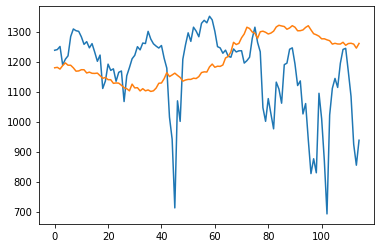

In [436]:
plt.plot(scaler.inverse_transform(model_lstm.predict(xtest)))
plt.plot(scaler.inverse_transform(ytest.reshape(-1,1)))

In [ ]:
a = scaler.inverse_transform(model_lstm.predict(xtest))[:, 0]
b = scaler.inverse_transform(ytest.reshape(-1,1))[:, 0]

for i, j in zip(a, b):
    print("preds:", i, "real:", j)

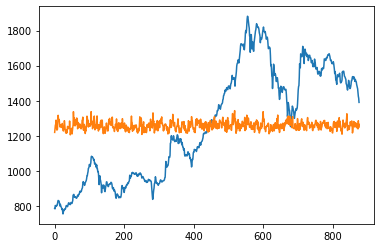

In [324]:
plt.plot(ytr)
plt.plot(model_lstm.predict(xtr))